# Tutorial - Galton Board

## What is a Galton Board? (from [Wikipedia](https://en.wikipedia.org/wiki/Galton_board))

The Galton board, also known as the Galton box or quincunx or bean machine, is a device invented by Sir Francis Galton to demonstrate the central limit theorem, in particular that with sufficient sample size the binomial distribution approximates a normal distribution. Among its applications, it afforded insight into regression to the mean or "reversion to mediocrity".

The Galton board consists of a vertical board with interleaved rows of pegs. Beads are dropped from the top and, when the device is level, bounce either left or right as they hit the pegs. Eventually they are collected into bins at the bottom, where the height of bead columns accumulated in the bins approximate a bell curve. Overlaying Pascal's triangle onto the pins shows the number of different paths that can be taken to get to each bin. 

![Galton Board gif](https://64.media.tumblr.com/02df8ba13155a78eab4bfb054d195684/tumblr_p5wrk7ZIYX1w6skpso1_500.gifv)

## Simulation

First, we need to import packages we will use, that is PyMCSL, NumPy and PyPlot.

In [1]:
import pymcsl as mcs
import numpy as np
import matplotlib.pyplot as plt

Now, we need to create a MonteCarloSimulationEnv instance. This environment will contain a variable 'x' of type **int** that will indicate the horizontal position of the bead along its trajectory to the bins. The starting position of all beads is 0.

For each bead, a sub-simulation will be performed (see the documentation for more on sub-simulations). As we want to simulate 1000 beads, the number of subsimulations will be set to 1000.

Each step simulates the bead passing through a row of pegs. We want to simulate a Galton board with 100 rows of pegs, so the number of steps will be set to 100.

In [2]:
N_SUBSIMULATIONS = 1000
N_STEPS = 100

env = mcs.MonteCarloSimulationEnv(
    variables=[
        ('x', int, 0)
    ],
    n_subsimulations = N_SUBSIMULATIONS,
    n_steps = N_STEPS
)

When the bead passes through a row of pegs, it is moved left or right by a peg. The move to the left will be indicated by a decrement of 1 in the variable 'x', and the move to the right will be indicated by an increment of 1 in 'x'.

We will create two functions: **beginf** and **stepf**. The function **beginf** will be executed at the beginning of each subsimulation, before the first step, and the function **stepf** will be executed at each step of the subsimulation. The **beginf** function must be signed with the **env.subsim_begin** decorator, and the **stepf** function must be signed with the **env.subsim_step** decorator.

Both functions have a first parameter called 'context'. This parameter takes a **ContextType** object that gives read and write access to the current states of all variables, and also allows old states (from previous steps) to be read using the **past** method. The **stepf** function has, in addition to the context parameter, a 'step' parameter, which receives the index of the current step (starting with 0).

In the body of the **beginf** function, we instantiate a **DiscreteRandomVariable** object and store its reference in a 'direction' attribute in the context. This attribute is not a variable, but an auxiliary. Auxiliary attributes can be created at any time in the subsimulation without being previously declared (as variables should be), and they have no state history record. This **DiscreteRandomVariable** object is a random variable with alphabet $\Omega=\{-1,1\}$ and probabilities $P(-1)=1/2$ and $P(1)=1/2$. In each step of the simulation, a random outcome of this variable will be obtained and incremented to the state of the variable 'x' to simulate a movement to the left or to the right of the bead.

In [3]:
LEFT = -1
RIGHT = 1

@env.subsim_begin
def beginf(context):
    context.direction = mcs.DiscreteRandomVariable({
        LEFT: 0.5,
        RIGHT: 0.5
    })
    
@env.subsim_step
def stepf(context, step):
    context.x += context.direction.evaluate()

Now, run the Monte Carlo simulation using the **run** method.

In [4]:
env.run()

100%|██████████| 1000/1000 [00:01<00:00, 567.67it/s]


To obtain the history of states of the variable 'x' throughout each subsimulation, we can use the **get_variable_histories** method. This method returns a NumPy array whose rows are subsimulations and columns are steps.

In the following code cell, we use the array returned by the **get_variable_histories** method to plot the trajectory of each bead over time.

No handles with labels found to put in legend.


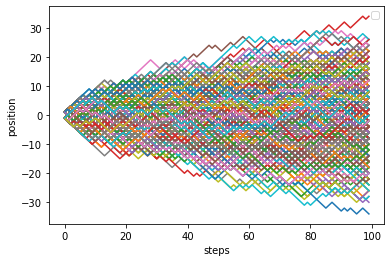

In [5]:
xh = env.get_variable_histories('x') #xh[subsim index, step index]

for subsim_index in range(N_SUBSIMULATIONS):
    plt.plot(xh[subsim_index, :])

plt.xlabel('steps')
plt.ylabel('position')
plt.legend()
plt.show()

We can obtain statistical measures such as mean, median, variance, and standard deviation of the variable's outcomes for each step using the MonteCarloSimulationEnv class methods, as shown in the following code cell.

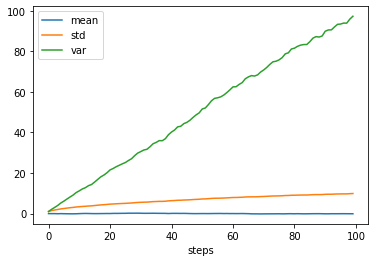

In [6]:
plt.plot(env.get_variable_mean('x'), label='mean')
plt.plot(env.get_variable_std('x'), label='std')
plt.plot(env.get_variable_var('x'), label='var')
plt.xlabel('steps')
plt.legend()
plt.show()

We can also plot the minimum, maximum and median outcomes of each step. But attention, this is different from plotting the paths with lower end position or higher end position.

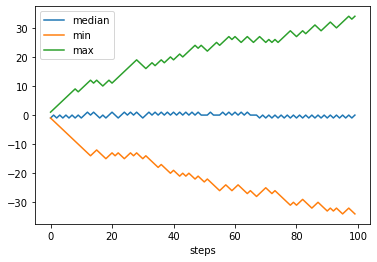

In [7]:
plt.plot(env.get_variable_median('x'), label='median')
plt.plot(env.get_variable_min('x'), label='min')
plt.plot(env.get_variable_max('x'), label='max')
plt.xlabel('steps')
plt.legend()
plt.show()

We can use the **get_variable_histogram** method to get a histogram of a variable for each step.

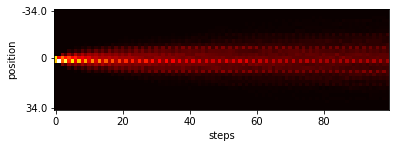

In [8]:
N_BINS = 30
xhistogram = env.get_variable_histogram('x', n_bins=N_BINS) #xhistogram[step_index, bin_index]
plt.imshow(np.transpose(xhistogram), cmap='hot')
plt.xlabel('steps')
plt.ylabel('position')
plt.yticks([0, N_BINS//2-1, N_BINS-1], [env.get_variable_min('x', domain=None), 0, env.get_variable_max('x', domain=None)])
plt.show()

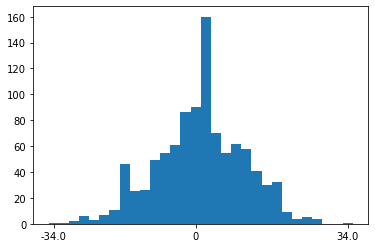

In [9]:
bar_width = 10
plt.bar([i*bar_width for i in range(N_BINS)], xhistogram[N_STEPS-1, :], bar_width)
plt.xticks([0, (N_BINS//2-1)*bar_width, (N_BINS-1)*bar_width], [env.get_variable_min('x', domain=None), 0, env.get_variable_max('x', domain=None)])
plt.show()

Note that the histograms above look inconsistent. This happened because the get_variable_histogram method used bins delimited by the minimum outcome of the variable and the maximum outcome of the variable, which does not correspond to the bins of a real Galton board. We can fix this by manually delimiting a range, as the following code cell shows:

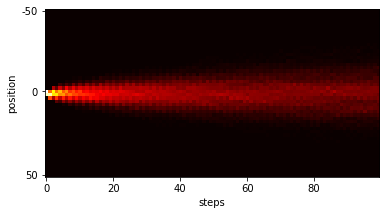

In [10]:
N_BINS = 50
xhistogram = env.get_variable_histogram('x', n_bins=N_BINS, _range=(-50,50)) #xhistogram[step_index, bin_index]
plt.imshow(np.transpose(xhistogram), cmap='hot')
plt.xlabel('steps')
plt.ylabel('position')
plt.yticks([0, N_BINS//2-1, N_BINS-1], [-50, 0, 50])
plt.show()

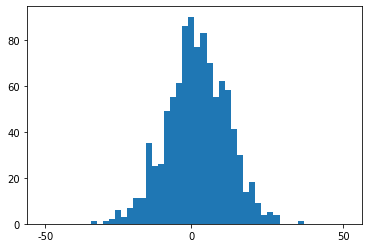

In [11]:
bar_width = 10
plt.bar([i*bar_width for i in range(N_BINS)], xhistogram[N_STEPS-1, :], bar_width)
plt.xticks([0, (N_BINS//2-1)*bar_width, (N_BINS-1)*bar_width], [-50, 0, 50])
plt.show()